# Tutorial 2: Synapse Models

In this tutorial, you'll learn:

- What synapses do in neural networks
- Different synapse models (Expon, Alpha, AMPA, GABAa)
- How to compare synapse dynamics
- When to use each synapse type
- How to create custom synapses

In [2]:
import brainpy
import brainstate
import brainunit as u
import braintools
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np

## Part 1: Understanding Synapses

Synapses perform **temporal filtering** of spike trains:

```
Discrete Spikes → [Synapse] → Continuous Signal
```

They model:
- Postsynaptic potentials (PSPs)
- Rise and decay kinetics
- Neurotransmitter dynamics

## Part 2: Exponential Synapse (Expon)

The simplest model: single exponential decay.

$$\tau \frac{dg}{dt} = -g$$

When spike arrives: $g \leftarrow g + 1$

In [3]:
# Set time step
brainstate.environ.set(dt=0.1 * u.ms)

# Create exponential synapse
expon_syn = brainpy.state.Expon(
    in_size=1,
    tau=5. * u.ms,
    g_initializer=braintools.init.Constant(0. * u.mS)
)

# Initialize
brainstate.nn.init_all_states(expon_syn)

print(f"Created Expon synapse with tau={expon_syn.tau}")

Created Expon synapse with tau=5.0 * msecond


In [4]:
# Simulate response to single spike
brainstate.nn.init_all_states(expon_syn)

duration = 50. * u.ms
dt = brainstate.environ.get_dt()
times = u.math.arange(0. * u.ms, duration, dt)

responses = []
for i, t in enumerate(times):
    # Spike at t=0
    # spike = 1.0 if i == 0 else 0.0
    # expon_syn(jnp.array([spike]))
    spike = 1.0 * u.mS if i == 0 else 0.0 * u.mS
    expon_syn(u.math.asarray([spike]))
    responses.append(expon_syn.g.value[0])

responses = u.math.asarray(responses)

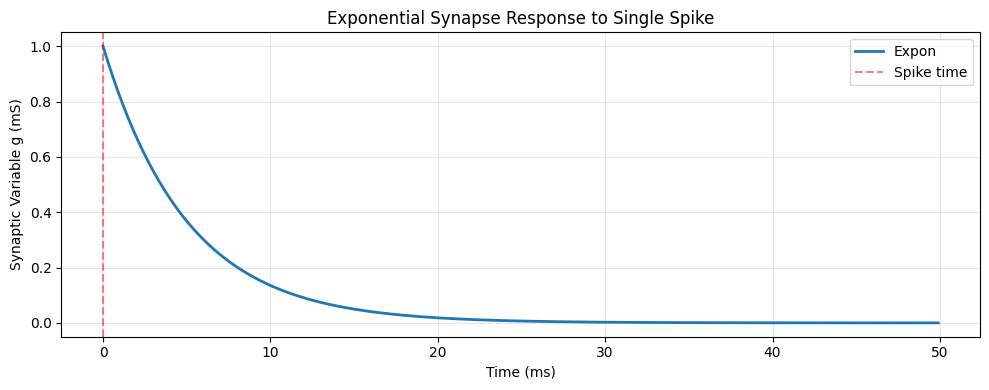

Observation: Instantaneous rise, exponential decay


In [5]:
# Plot response
plt.figure(figsize=(10, 4))
plt.plot(times.to_decimal(u.ms), responses.to_decimal(u.mS), linewidth=2, label='Expon')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5, label='Spike time')
plt.xlabel('Time (ms)')
plt.ylabel('Synaptic Variable g (mS)')
plt.title('Exponential Synapse Response to Single Spike')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Observation: Instantaneous rise, exponential decay")

## Part 3: Alpha Synapse

More realistic: gradual rise and decay.

$$\tau \frac{dh}{dt} = -h$$
$$\tau \frac{dg}{dt} = -g + h$$

Response: $g(t) = \frac{t}{\tau} e^{-t/\tau}$

In [6]:
# Create alpha synapse
alpha_syn = brainpy.state.Alpha(
    in_size=1,
    tau=5. * u.ms,
    g_initializer=braintools.init.Constant(0. * u.mS)
)

brainstate.nn.init_all_states(alpha_syn)

# Simulate
alpha_responses = []
for i, t in enumerate(times):
    spike = 1.0 * u.mS if i == 0 else 0.0 * u.mS
    alpha_syn(u.math.asarray([spike]))
    alpha_responses.append(alpha_syn.g.value[0])

alpha_responses = u.math.asarray(alpha_responses)

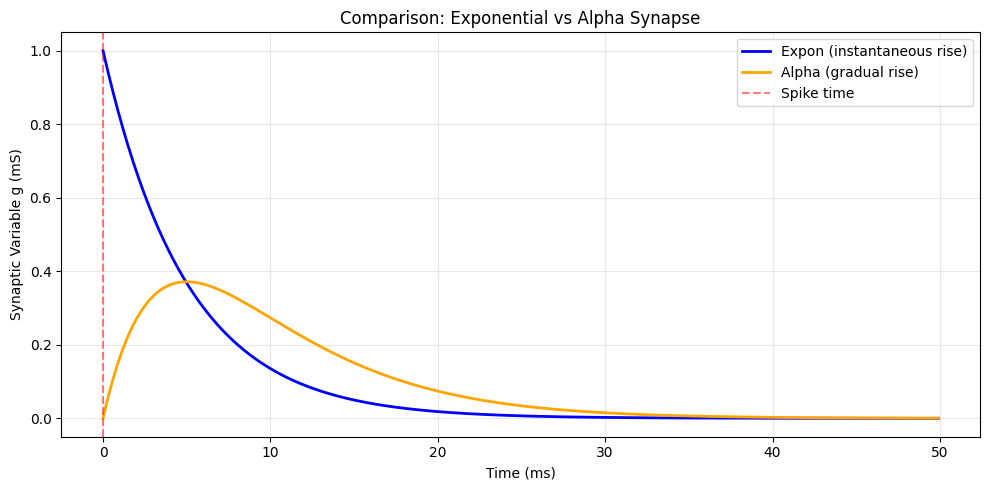

Key difference: Alpha has realistic rise time, peak at t=τ


In [7]:
# Compare Expon vs Alpha
plt.figure(figsize=(10, 5))
plt.plot(times.to_decimal(u.ms), responses.to_decimal(u.mS), 
         linewidth=2, label='Expon (instantaneous rise)', color='blue')
plt.plot(times.to_decimal(u.ms), alpha_responses.to_decimal(u.mS), 
         linewidth=2, label='Alpha (gradual rise)', color='orange')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5, label='Spike time')
plt.xlabel('Time (ms)')
plt.ylabel('Synaptic Variable g (mS)')
plt.title('Comparison: Exponential vs Alpha Synapse')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Key difference: Alpha has realistic rise time, peak at t=τ")

## Part 4: AMPA and GABAa Synapses

Biologically parameterized models:

- **AMPA**: Fast excitatory (τ ≈ 2 ms)
- **GABAa**: Slower inhibitory (τ ≈ 10 ms)

In [8]:
# Create AMPA synapse (fast excitatory)
ampa_syn = brainpy.state.AMPA(
    in_size=1,
    T=2. * u.ms,
    g_initializer=braintools.init.Constant(0. * u.mS)
)

# Create GABAa synapse (slower inhibitory)
gaba_syn = brainpy.state.GABAa(
    in_size=1,
    T_dur=10. * u.ms,
    g_initializer=braintools.init.Constant(0. * u.mS)
)

brainstate.nn.init_all_states(ampa_syn)
brainstate.nn.init_all_states(gaba_syn)

print(f"AMPA tau: {ampa_syn.T} (fast)")
print(f"GABAa tau: {gaba_syn.T} (slow)")

AMPA tau: 2.0 * msecond (fast)
GABAa tau: 1.0 * mmolar (slow)


In [ ]:
# Simulate both
ampa_responses = []
gaba_responses = []

for i, t in enumerate(times):
    spike = 1.0 if i == 0 else 0.0
    ampa_syn(jnp.array([spike]))
    gaba_syn(jnp.array([spike]))
    ampa_responses.append(ampa_syn.g.value[0])
    gaba_responses.append(gaba_syn.g.value[0])

ampa_responses = u.math.asarray(ampa_responses)
gaba_responses = u.math.asarray(gaba_responses)

In [ ]:
# Plot all four synapse types
plt.figure(figsize=(12, 6))

plt.plot(times.to_decimal(u.ms), responses.to_decimal(u.mS), 
         linewidth=2, label='Expon (τ=5ms)', alpha=0.7)
plt.plot(times.to_decimal(u.ms), alpha_responses.to_decimal(u.mS), 
         linewidth=2, label='Alpha (τ=5ms)', alpha=0.7)
plt.plot(times.to_decimal(u.ms), ampa_responses.to_decimal(u.mS), 
         linewidth=2, label='AMPA (τ=2ms, fast excitatory)', linestyle='--')
plt.plot(times.to_decimal(u.ms), gaba_responses.to_decimal(u.mS), 
         linewidth=2, label='GABAa (τ=10ms, slow inhibitory)', linestyle='--')

plt.axvline(x=0, color='r', linestyle=':', alpha=0.5, label='Spike time')
plt.xlabel('Time (ms)', fontsize=12)
plt.ylabel('Synaptic Variable g (mS)', fontsize=12)
plt.title('Comparison of All Synapse Models', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nObservations:")
print("- AMPA: Fastest decay (excitatory transmission)")
print("- GABAa: Slowest decay (prolonged inhibition)")
print("- Alpha models have realistic rise time")
print("- Expon models are computationally faster")

## Part 5: Response to Spike Trains

How do synapses integrate multiple spikes?

In [13]:
# Create spike train: 5 spikes at 50 Hz (20ms intervals)
brainstate.nn.init_all_states(expon_syn)
brainstate.nn.init_all_states(alpha_syn)

duration = 150. * u.ms
times = u.math.arange(0. * u.ms, duration, dt)
spike_times = [0, 20, 40, 60, 80]  # ms

expon_train_resp = []
alpha_train_resp = []

for i, t in enumerate(times):
    t_ms = t.to_decimal(u.ms)
    spike = 1.0 *u.mS if any(abs(t_ms - st) < 0.1 for st in spike_times) else 0.0 *u.mS
    
    expon_syn(u.math.asarray([spike]))
    alpha_syn(u.math.asarray([spike]))
    
    expon_train_resp.append(expon_syn.g.value[0])
    alpha_train_resp.append(alpha_syn.g.value[0])

expon_train_resp = u.math.asarray(expon_train_resp)
alpha_train_resp = u.math.asarray(alpha_train_resp)

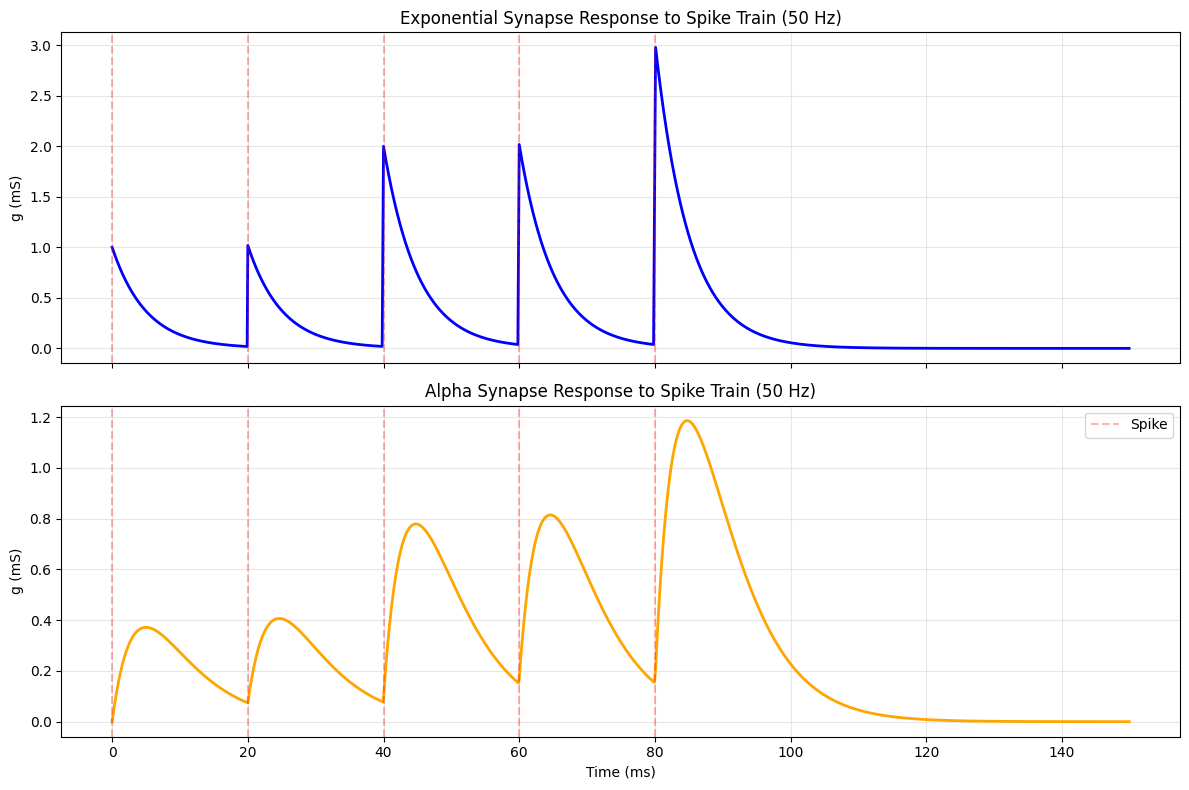

Temporal summation: synaptic responses accumulate over time


In [ ]:
# Plot spike train responses
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Expon response
axes[0].plot(times.to_decimal(u.ms), expon_train_resp.to_decimal(u.mS), 
             linewidth=2, color='blue')
for st in spike_times:
    axes[0].axvline(x=st, color='r', linestyle='--', alpha=0.3)
axes[0].set_ylabel('g (mS)')
axes[0].set_title('Exponential Synapse Response to Spike Train (50 Hz)')
axes[0].grid(True, alpha=0.3)

# Alpha response
axes[1].plot(times.to_decimal(u.ms), alpha_train_resp.to_decimal(u.mS), 
             linewidth=2, color='orange')
for st in spike_times:
    axes[1].axvline(x=st, color='r', linestyle='--', alpha=0.3, label='Spike' if st == 0 else '')
axes[1].set_ylabel('g (mS)')
axes[1].set_xlabel('Time (ms)')
axes[1].set_title('Alpha Synapse Response to Spike Train (50 Hz)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Temporal summation: synaptic responses accumulate over time")

## Part 6: Effect of Time Constant

How does τ affect synapse dynamics?

In [ ]:
# Compare different time constants
taus = [2*u.ms, 5*u.ms, 10*u.ms, 20*u.ms]
synapses = [brainpy.state.Expon(1, tau=tau) for tau in taus]

for syn in synapses:
    brainstate.nn.init_all_states(syn)

# Simulate
duration = 100. * u.ms
times = u.math.arange(0. * u.ms, duration, dt)

responses_by_tau = {}
for tau, syn in zip(taus, synapses):
    resp = []
    for i, t in enumerate(times):
        spike = 1.0 * u.mS if i == 0 else 0.0 * u.mS
        syn(u.math.asarray([spike]))
        resp.append(syn.g.value[0])
    responses_by_tau[tau] = u.math.asarray(resp)

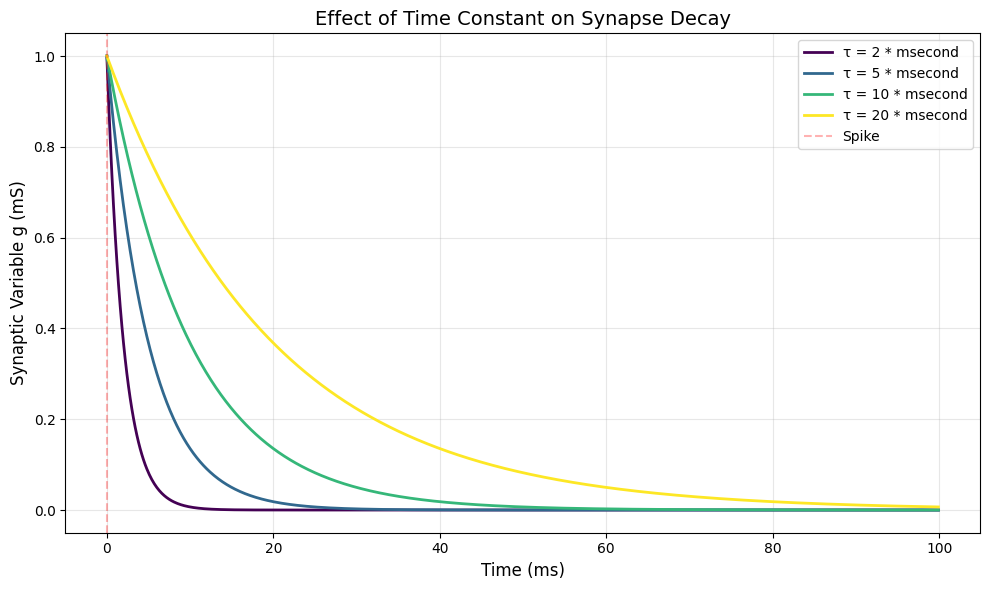


Effect of τ:
- Smaller τ → faster decay, less temporal summation
- Larger τ → slower decay, more temporal summation
- Choose τ based on biological constraints and computational needs


In [ ]:
# Plot effect of tau
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, len(taus)))
for (tau, resp), color in zip(responses_by_tau.items(), colors):
    plt.plot(times.to_decimal(u.ms), resp.to_decimal(u.mS), 
             linewidth=2, label=f'τ = {tau}', color=color)

plt.axvline(x=0, color='r', linestyle='--', alpha=0.3, label='Spike')
plt.xlabel('Time (ms)', fontsize=12)
plt.ylabel('Synaptic Variable g (mS)', fontsize=12)
plt.title('Effect of Time Constant on Synapse Decay', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nEffect of τ:")
print("- Smaller τ → faster decay, less temporal summation")
print("- Larger τ → slower decay, more temporal summation")
print("- Choose τ based on biological constraints and computational needs")

## Part 7: Synapses in Networks (Preview)

Synapses are used within projections. Here's a preview:

In [ ]:
# Create neurons
pre_neurons = brainpy.state.LIF(10, V_rest=-65.*u.mV, V_th=-50.*u.mV, tau=10.*u.ms)
post_neurons = brainpy.state.LIF(5, V_rest=-65.*u.mV, V_th=-50.*u.mV, tau=10.*u.ms)

# Create projection with exponential synapse
projection = brainpy.state.AlignPostProj(
    comm=brainstate.nn.EventFixedProb(
        10, 5, 0.5, 0.5*u.mS
    ),
    syn=brainpy.state.Expon.desc(5, tau=5.*u.ms),  # Synapse descriptor
    out=brainpy.state.CUBA.desc(),
    post=post_neurons
)

print("Synapse integrated into projection!")
print(f"Synapse type: {type(projection.syn).__name__}")
print(f"Synapse tau: {projection.syn.tau}")
print("\nSee Tutorial 3 for complete network building!")

Synapse integrated into projection!
Synapse type: Expon
Synapse tau: 5.0 * msecond

See Tutorial 3 for complete network building!


## Part 8: When to Use Each Synapse Type

### Decision Guide

**Use Expon when:**
- Speed is critical
- Training SNNs
- Large-scale simulations
- Precise kinetics not needed

**Use Alpha when:**
- Biological realism matters
- Detailed cortical models
- Comparing to experimental data
- Rise time is important

**Use AMPA when:**
- Excitatory synapses
- Fast glutamatergic transmission
- Cortical excitatory neurons

**Use GABAa when:**
- Inhibitory synapses
- GABAergic interneurons
- Slower inhibition needed

## Part 9: Creating Custom Synapses

You can create custom synapse models:

In [ ]:
from brainpy.state import Synapse

class DoubleExpSynapse(Synapse):
    """Synapse with different rise and decay time constants."""
    
    def __init__(self, size, tau_rise, tau_decay, **kwargs):
        super().__init__(size, **kwargs)
        
        self.tau_rise = tau_rise
        self.tau_decay = tau_decay
        
        # Two state variables
        self.h = brainstate.ShortTermState(
            braintools.init.Constant(0., unit=u.mS)(size)
        )
        self.g = brainstate.ShortTermState(
            braintools.init.Constant(0., unit=u.mS)(size)
        )
    
    def update(self, spike_input):
        dt = brainstate.environ.get_dt()
        
        # Rise dynamics
        dh = -self.h.value / self.tau_rise
        self.h.value = self.h.value + dh * dt + spike_input * u.mS
        
        # Decay dynamics
        dg = -self.g.value / self.tau_decay + self.h.value / self.tau_rise
        self.g.value = self.g.value + dg * dt
        
        return self.g.value
    
    @classmethod
    def desc(cls, size, tau_rise, tau_decay, **kwargs):
        def create():
            return cls(size, tau_rise, tau_decay, **kwargs)
        return create

# Test custom synapse
custom_syn = DoubleExpSynapse(
    size=1, 
    tau_rise=1.*u.ms, 
    tau_decay=10.*u.ms
)
brainstate.nn.init_all_states(custom_syn)

print("Custom synapse created!")
print(f"Rise time: {custom_syn.tau_rise}")
print(f"Decay time: {custom_syn.tau_decay}")

Custom synapse created!
Rise time: 1.0 * msecond
Decay time: 10.0 * msecond


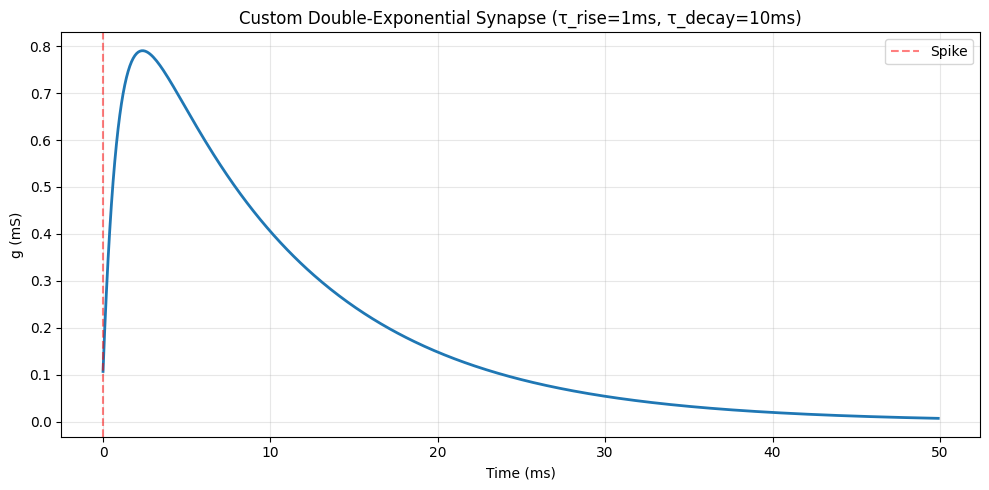

Custom synapse shows fast rise (1ms) and slow decay (10ms)


In [ ]:
# Test custom synapse
custom_resp = []
duration = 50. * u.ms
times = u.math.arange(0. * u.ms, duration, dt)

for i, t in enumerate(times):
    spike = 1.0 if i == 0 else 0.0
    custom_syn(jnp.array([spike]))
    custom_resp.append(custom_syn.g.value[0])

custom_resp = u.math.asarray(custom_resp)

plt.figure(figsize=(10, 5))
plt.plot(times.to_decimal(u.ms), custom_resp.to_decimal(u.mS), linewidth=2)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5, label='Spike')
plt.xlabel('Time (ms)')
plt.ylabel('g (mS)')
plt.title('Custom Double-Exponential Synapse (τ_rise=1ms, τ_decay=10ms)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Custom synapse shows fast rise (1ms) and slow decay (10ms)")

## Summary

In this tutorial, you learned:

✅ How synapses perform temporal filtering

✅ Four synapse models: Expon, Alpha, AMPA, GABAa

✅ Differences in rise time and decay kinetics

✅ Response to single spikes and spike trains

✅ Effect of time constant τ

✅ When to use each synapse type

✅ How to create custom synapses

## Next Steps

- **Tutorial 3**: Learn to [build connected networks](03-network-connections.ipynb)
- **Core Concepts**: Read detailed [synapse documentation](../../core-concepts/synapses.rst)
- **Examples**: See synapses in action in the [examples gallery](../../examples/gallery.rst)

## Exercises

Try these on your own:

1. Compare AMPA vs GABAa responses to a 100 Hz spike train
2. Find the τ value where peak response to a 50 Hz train is maximized
3. Implement an NMDA synapse (voltage-dependent)
4. Create a synapse with adaptation (decrease response over time)